In [1]:
# This code works in Python 3.10.6
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import dgl
import random
import torch
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
import torch_geometric.utils.convert
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
import import_ipynb
#PubMed dataset with all features
import pubmed_dataset

importing Jupyter notebook from pubmed_dataset.ipynb
HeteroData(
  disease={
    x=[454, 200],
    y=[454],
  },
  gene={ x=[13561, 200] },
  chemical={ x=[26522, 200] },
  species={ x=[2863, 200] },
  (gene, to, gene)={ edge_index=[2, 40] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 70] },
  (chemical, to, chemical)={ edge_index=[2, 108] },
  (chemical, to, species)={ edge_index=[2, 18] },
  (species, to, gene)={ edge_index=[2, 6] }
)


In [3]:
import import_ipynb
import pubmed_dataset

In [4]:
data = pubmed_dataset.data

In [5]:
dataset = data.clone()
# Node features are removed as a temporary fix to the errors in conversion of 
#Pytorch Geometric HeteroData to DGL graph. Node features are not important for creating metagraph.
dataset['disease'].x = dataset['disease'].x[:405, :]
dataset['disease'].y = dataset['disease'].y[:405]
dataset['gene'].x = dataset['gene'].x[:13499, :]
dataset['chemical'].x = dataset['chemical'].x[:26406, :]
dataset['species'].x = dataset['species'].x[:2741, :]

In [6]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(dataset)
meta_g= g.metagraph()

Train PubMed

In [7]:
transform = T.RandomNodeSplit(split='train_rest', num_val=0.15, num_test=0.15)
data = transform(data)
data

HeteroData(
  disease={
    x=[454, 200],
    y=[454],
    train_mask=[454],
    val_mask=[454],
    test_mask=[454],
  },
  gene={ x=[13561, 200] },
  chemical={ x=[26522, 200] },
  species={ x=[2863, 200] },
  (gene, to, gene)={ edge_index=[2, 40] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 70] },
  (chemical, to, chemical)={ edge_index=[2, 108] },
  (chemical, to, species)={ edge_index=[2, 18] },
  (species, to, gene)={ edge_index=[2, 6] }
)

In [8]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['disease'])


model = HeteroGNN(data.metadata(), hidden_channels=256, out_channels=8,
                  num_layers=4)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['disease'].train_mask
    loss = F.cross_entropy(out[mask], data['disease'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['disease'][split]
        acc = (pred[mask] == data['disease'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 010, Loss: 0.9531, Train: 0.7075, Val: 0.4559, Test: 0.4412
Epoch: 020, Loss: 0.2244, Train: 0.9277, Val: 0.5735, Test: 0.5588
Epoch: 030, Loss: 0.0514, Train: 0.9308, Val: 0.5294, Test: 0.5441
Epoch: 040, Loss: 0.0474, Train: 0.9937, Val: 0.5000, Test: 0.5294
Epoch: 050, Loss: 0.0118, Train: 1.0000, Val: 0.5147, Test: 0.5147
Epoch: 060, Loss: 0.0042, Train: 1.0000, Val: 0.4853, Test: 0.5294
Epoch: 070, Loss: 0.0030, Train: 1.0000, Val: 0.4559, Test: 0.5294
Epoch: 080, Loss: 0.0036, Train: 1.0000, Val: 0.4559, Test: 0.5294
Epoch: 090, Loss: 0.0048, Train: 1.0000, Val: 0.4412, Test: 0.4853
Epoch: 100, Loss: 0.0059, Train: 1.0000, Val: 0.4559, Test: 0.4853


In [9]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [10]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [11]:
def get_node_type(node_type):
    if node_type == 1:
        return 'disease'
    elif node_type == 0:
        return 'gene'
    elif node_type == 2:
        return 'chemical'
    elif node_type == 3:
        return 'species'

In [12]:
all_edges = {}

In [13]:
#List of edges in metagraph of PubMed
list(meta_g.edges())

[('chemical', 'chemical'),
 ('chemical', 'gene'),
 ('chemical', 'species'),
 ('gene', 'disease'),
 ('gene', 'gene'),
 ('species', 'gene')]

In [14]:
def create_dataset(nodes,edges,disease_df,gene_df,chemical_df,species_df,node_id,df_graph):
    disease = np.asarray(disease_df.drop(columns=['class']))
    gene = np.asarray(gene_df)
    chemical = np.asarray(chemical_df)
    species = np.asarray(species_df)
    

    x_disease = torch.tensor(disease).to(dtype=torch.float32)
    y_disease = torch.tensor(np.array(disease_df["class"]), dtype=torch.long)
    x_gene = torch.tensor(gene).to(dtype=torch.float32)
    x_chemical = torch.tensor(chemical).to(dtype=torch.float32)
    x_species = torch.tensor(species).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    chemical_to_chemical = []
    chemical_to_gene = []
    chemical_to_species = []
    gene_to_disease = []
    gene_to_gene = []
    species_to_gene = []
    remaining_edges = []

    class_dict = {'Gene':0, 'Disease':1, 'Chemical':2,'Species':3}

    for i in range(len(edges)):
        if (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0]== class_dict['Chemical']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Chemical']):
                chemical_to_chemical.append((int(source[i]),int(dest[i])))
            
        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Chemical']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Gene']):
                chemical_to_gene.append((int(source[i]),int(dest[i])))
            
        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Chemical']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Species']):
                chemical_to_species.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Gene']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Disease']):
                gene_to_disease.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Gene']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Gene']):
                gene_to_gene.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Species']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Gene']):
                species_to_gene.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0])
            dest_node_type = get_node_type(df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0])
            remaining_edges.append((source_node_type,dest_node_type))
            #remaining_edges.append((int(source[i]),int(dest[i])))
            
    all_edges[node_id] = [*chemical_to_chemical,*chemical_to_gene,*chemical_to_species,
                          *gene_to_disease,*gene_to_gene,*species_to_gene]
            
    disease = list(df_graph[df_graph['class'] == 1]['nodeId'])
    disease = [int(i) for i in disease]
    disease_nodes_mapping = remap_indices(disease)
    
    gene = list(df_graph[df_graph['class'] == 0]['nodeId'])
    gene = [int(i) for i in gene]
    gene_nodes_mapping = remap_indices(gene)
    
    chemical = list(df_graph[df_graph['class'] == 2]['nodeId'])
    chemical = [int(i) for i in chemical]
    chemical_nodes_mapping = remap_indices(chemical)
    
    species = list(df_graph[df_graph['class'] == 3]['nodeId'])
    species = [int(i) for i in species]
    species_nodes_mapping = remap_indices(species)


    node_list = {}
    for d in [disease_nodes_mapping, gene_nodes_mapping, chemical_nodes_mapping,species_nodes_mapping]:
        node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'disease':{'x': x_disease, 'y':y_disease}, 'gene':{'x': x_gene},
                              'chemical':{'x': x_chemical}, 'species':{'x': x_species}})

    if chemical_to_chemical:
        edge_index_chemical_chemical = preprocess_edges(chemical_to_chemical,node_list)
        small_graph['chemical','to','chemical'].edge_index = edge_index_chemical_chemical
    if chemical_to_gene:
        edge_index_chemical_gene = preprocess_edges(chemical_to_gene,node_list)
        small_graph['chemical','to','gene'].edge_index = edge_index_chemical_gene
    if chemical_to_species:
        edge_index_chemical_species = preprocess_edges(chemical_to_species,node_list)
        small_graph['chemical','to','species'].edge_index = edge_index_chemical_species
    if gene_to_disease:
        edge_index_gene_disease = preprocess_edges(gene_to_disease,node_list)
        small_graph['gene','to','disease'].edge_index = edge_index_gene_disease
    if gene_to_gene:
        edge_index_gene_gene = preprocess_edges(gene_to_gene,node_list)
        small_graph['gene','to','gene'].edge_index = edge_index_gene_gene
    if species_to_gene:
        edge_index_species_gene = preprocess_edges(species_to_gene,node_list)
        small_graph['species','to','gene'].edge_index = edge_index_species_gene

    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)
    
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)

    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph, remaining_edges

In [15]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['disease'].test_mask
        correct = (pred[mask] == small_graph['disease'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['disease'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [16]:
def get_real_graph(size):
    real_graph = nx.Graph()
    if(size <= 5):
        real_graph = nx.read_gexf(real_graph_path+'real_G5.gexf')
    elif(size <= 10):
        real_graph = nx.read_gexf(real_graph_path+'real_G10.gexf')
    elif(size <= 15):
        real_graph = nx.read_gexf(real_graph_path+'real_G15.gexf')
    elif(size <= 20):
        real_graph = nx.read_gexf(real_graph_path+'real_G20.gexf')
    elif(size <= 25):
        real_graph = nx.read_gexf(real_graph_path+'real_G25.gexf')
    elif(size <= 30):
        real_graph = nx.read_gexf(real_graph_path+'real_G30.gexf')
    elif(size <= 35):
        real_graph = nx.read_gexf(real_graph_path+'real_G35.gexf')


    return real_graph

In [17]:
print('Original no of graphs:',len([name for name in glob.glob('../syn_vae/pubmed/*')]))

Original no of graphs: 1184


In [18]:
softmax_dict = {}
nodefeature_dict = {}
graph_dict = {}
original_edge_count = []
removed_edge_count = []
removed_edges_list = []
rootdir = '../syn_vae/pubmed/'

real_graph_path = '../real_graphs/pubmed/'
dir_list = []
for subdir, dirs,files in os.walk(rootdir):
    
    if files:
        graph_path = os.path.join(subdir, files[0])
        class_path = os.path.join(subdir, files[1])       
        feature_path = os.path.join(subdir, files[2])

        graph = nx.read_gexf(graph_path)
        filename = os.path.basename(graph_path)
        graph_id= filename.split('.')[0]
            #print(graph_id)

        nodeId_list = []

        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            edges = [e for e in graph.edges]

        node_type_list = torch.load(class_path).detach().numpy()

        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list


        df_feature = pd.DataFrame(torch.load(feature_path).detach().numpy())        
        df_feature["class"] = node_type_list
    
        real_graph = get_real_graph(len(nodeId_list))

        node_label_list = []

        if not (nx.get_node_attributes(real_graph, "class") is None):
            node_class = nx.get_node_attributes(real_graph, "class")
            node_label_list.append(node_class.get('1'))

        disease_node_features = df_feature[df_feature['class'] == 1].drop(['class'], axis = 1)

        if not (None in node_label_list):
                
            labels = []
            unique_labels = list(set(node_label_list))
                
            for i in range(0,len(disease_node_features)):
                labels.append(random.choice(unique_labels))

            disease_node_features['class']= labels

            gene_node_features = df_feature[df_feature['class'] == 0].drop(['class'], axis = 1)
            chemical_node_features = df_feature[df_feature['class'] == 2].drop(['class'], axis = 1)
            species_node_features = df_feature[df_feature['class'] == 3].drop(['class'], axis = 1)



            small_graph_data, removed_edges = create_dataset(nodeId_list,edges,
                                      disease_node_features,gene_node_features,
                                      chemical_node_features,species_node_features,graph_id,df_graph)

            edge_list = all_edges[graph_id]
            graph = nx.Graph(edge_list)
            if not nx.is_empty(graph) and nx.is_connected(graph):


                if (small_graph_data['disease'].x.nelement()!=0) and \
                (small_graph_data['chemical','to','chemical']) and \
                (small_graph_data['chemical','to','species']):
                    print(graph_path)
                    print('node count',small_graph_data.num_nodes)
                    print('edge count',small_graph_data.num_edges)
        
                    original_edge_count.append(len(edges))
                    removed_edge_count.append(len(removed_edges))
                    removed_edges_list.append(set(removed_edges))
                    print('Original edge_count',len(edges))
                    print('Removed edge_count',len(removed_edges))
                    print('Removed edges',removed_edges)
                    
                    softmax, correct_indices = evaluate_gnn(small_graph_data)
                    softmax_dict[graph_id] = softmax
                    nodefeature_dict[graph_id]={'gene':small_graph_data['gene'].x,
                                                 'disease':small_graph_data['disease'].x[correct_indices],
                                                 'chemical':small_graph_data['chemical'].x,
                                                  'species':small_graph_data['species'].x}
                    graph_dict[graph_id]=df_graph

        
        

../syn_vae/pubmed/sync446174233453/sync446174233453_G27.gexf
node count 18
edge count 21
Original edge_count 32
Removed edge_count 11
Removed edges [('chemical', 'disease'), ('chemical', 'disease'), ('chemical', 'disease'), ('disease', 'disease'), ('disease', 'disease'), ('species', 'disease'), ('disease', 'species'), ('disease', 'gene'), ('disease', 'gene'), ('disease', 'gene'), ('gene', 'chemical')]
HeteroData(
  disease={
    x=[3, 200],
    y=[3],
    train_mask=[3],
    val_mask=[3],
    test_mask=[3],
  },
  gene={ x=[9, 200] },
  chemical={ x=[3, 200] },
  species={ x=[3, 200] },
  (chemical, to, chemical)={ edge_index=[2, 2] },
  (chemical, to, gene)={ edge_index=[2, 3] },
  (chemical, to, species)={ edge_index=[2, 2] },
  (gene, to, disease)={ edge_index=[2, 3] },
  (gene, to, gene)={ edge_index=[2, 8] },
  (species, to, gene)={ edge_index=[2, 3] }
)
Prediction: tensor([5, 1, 3])
Ground Truth: tensor([6, 6, 6])
tensor([False, False, False])
tensor([[2.6121e-06, 9.6057e-07, 1.2

In [19]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  10


In [46]:
print('Average number of original edges',round(np.mean(original_edge_count)))

Average number of original edges 31


In [47]:
print('Average number of edges removed',round(np.mean(removed_edge_count)))

Average number of edges removed 15


In [20]:
#Getting the list of predictions for each class
prob_class6_dict = {}
for nodeid in softmax_dict:
    list6= []
    if len(softmax_dict[nodeid]) > 0:
        list6= []

        for prob in softmax_dict[nodeid]:        
            list6.append(prob[6])


     #Taking max probability of all nodes of each class in a graph

    if len(list6) != 0:
        prob_class6_dict[nodeid]=max(list6)


In [21]:
max_pred6 = max(prob_class6_dict.values())
class6_graphid = max(prob_class6_dict, key=prob_class6_dict.get)
print(class6_graphid)

sync719797233518_G27


In [22]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():
        #print(g)
        #print(df_graph.loc[g]['class'])
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 0:
            classes.append(0)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 1:
            classes.append(1)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0]== 2:
            classes.append(2)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 3:
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

Plotting explanation graph with node features for each class of Disease node

Node colors:

Gene - Blue

Disease - Red

Chemical - Darkgreen

Species - Orange

Number of nodes:  18
graph id:  sync719797233518_G27
Max pred probability for class 6 is 0.8778218626976013


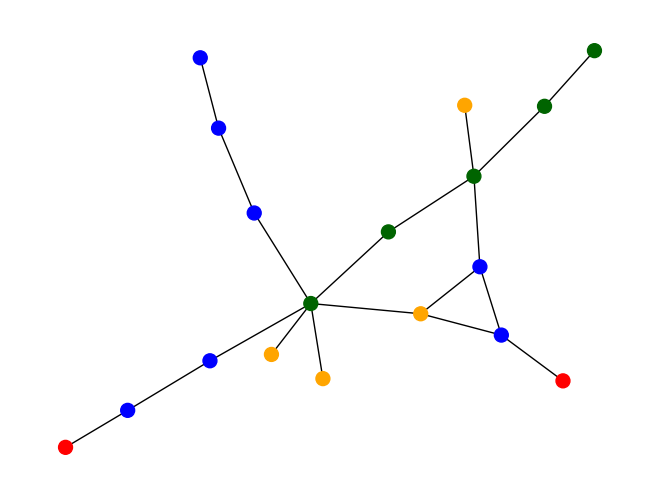

In [51]:
explanation_graph6 = plot_graph(class6_graphid, max_pred6, 6, all_edges[class6_graphid],graph_dict[class6_graphid])

In [49]:
def print_stat_cont_features(df):
    #print('summary',df.describe())
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [28]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [29]:
def plot_node_feat(imp_feat):

    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show() 

Text(0, 0.5, 'Density')

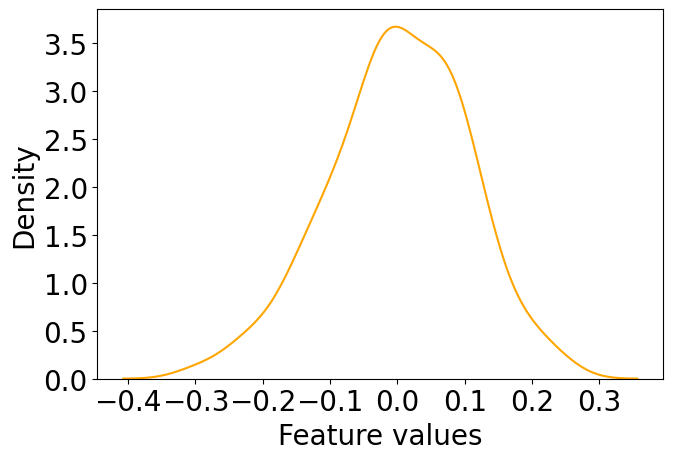

In [42]:
ind = index_2d(softmax_dict[class6_graphid], max_pred6)[0]
disease6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['disease'].numpy()[ind])
#plot_node_feat(disease6_df)
fig, ax = plt.subplots(figsize=(7.3,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(disease6_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [39]:
print_stat_cont_features(disease6_df)

mean 0.0010154528
std dev 0.10325434


In [32]:
gene6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['gene'].numpy())
print_stat_cont_features(gene6_df)

mean 0.00088273856
std dev 0.10234854


Text(0, 0.5, 'Density')

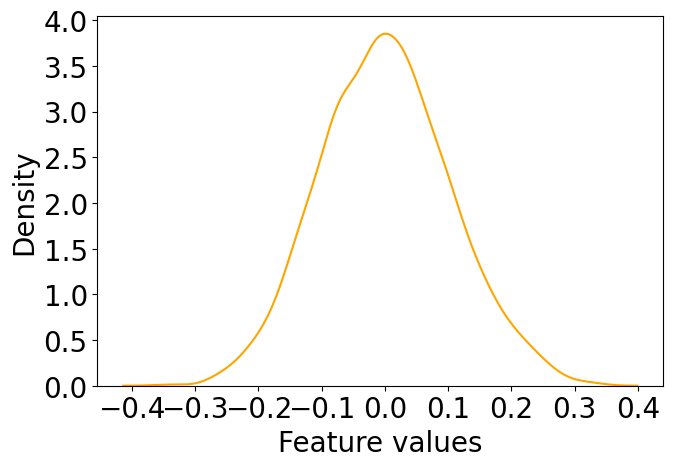

In [38]:
#plot_node_feat(gene6_df)
fig, ax = plt.subplots(figsize=(7.3,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(gene6_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [40]:
chemical6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['chemical'].numpy())
print_stat_cont_features(chemical6_df)

mean 0.0037535753
std dev 0.10455123


Text(0, 0.5, 'Density')

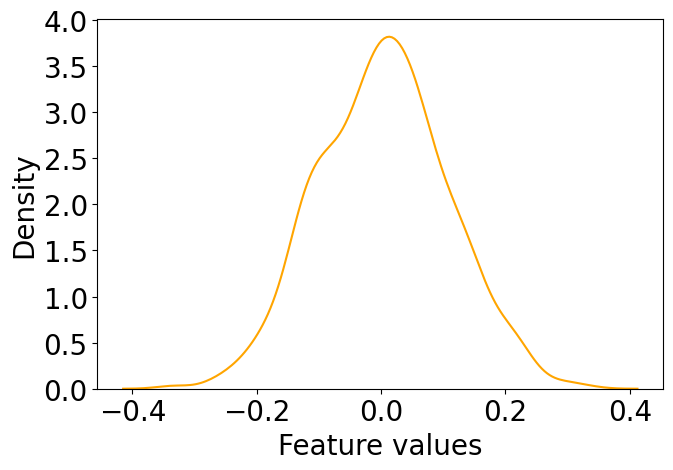

In [43]:
#plot_node_feat(chemical6_df)
fig, ax = plt.subplots(figsize=(7.3,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(chemical6_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)

In [44]:
species6_df = pd.DataFrame(nodefeature_dict[class6_graphid]['species'].numpy())
print_stat_cont_features(species6_df)

mean 0.0011008003
std dev 0.10600657


Text(0, 0.5, 'Density')

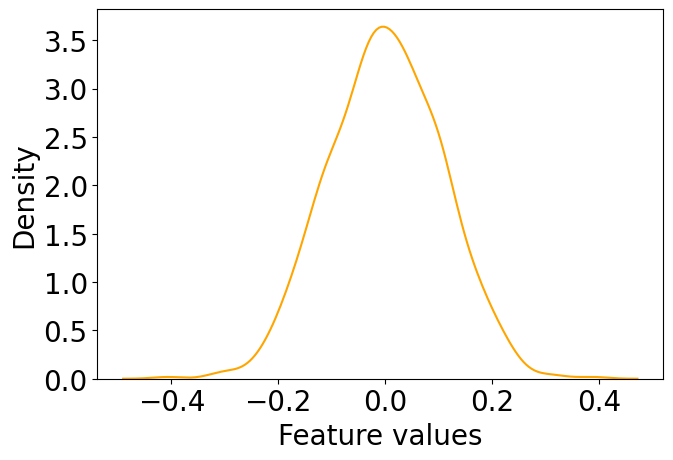

In [52]:
#plot_node_feat(species6_df)
fig, ax = plt.subplots(figsize=(7.3,4.8))
#ax.set_aspect('equal', 'datalim')
sns.distplot(species6_df,color= 'orange',hist= False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature values',fontsize=20)
plt.ylabel('Density',fontsize=20)